In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import rdkit.Chem as Chem 
import os  

### Collect the restuls (top 5 vs top 1)
### Aggregate into .csv file
### 

In [4]:
def select_conformations(input_sdf, output_sdf, top_n):
    suppl = Chem.SDMolSupplier(input_sdf)
    writer = Chem.SDWriter(output_sdf)
    
    for i, mol in enumerate(suppl):
        if mol is not None and i < top_n:
            writer.write(mol)
        if i >= top_n:
            break
    writer.close()

protein_name = "5SAK_ZRY"
input_path = f"/Users/aoxu/projects/DrugDiscovery/PoseBench/forks/ICM/inference/icm_manual_posebusters_benchmark_outputs_1/{protein_name}/answers_{protein_name}.sdf"
select_conformations(input_path, "rank1.sdf", 1)
select_conformations(input_path, "rank5.sdf", 5)

In [14]:
def top_n_conformation(protein_dir: str):
    input_sdf = os.path.join(protein_dir, f"answers_{protein_name}.sdf")
    """select the top n conformations from the input sdf file"""
    suppl = Chem.SDMolSupplier(input_sdf, removeHs=False)

    mols = []
    for mol in suppl:
        if mol is not None:
            score = float(mol.GetProp("Score"))  # Adjust property name as needed
            mols.append((mol, score))

    # Sort ascending (lowest score first)
    mols.sort(key=lambda x: x[1])

    # Write rank1.sdf
    if mols:
        w1 = Chem.SDWriter(os.path.join(protein_dir, "rank1.sdf"))
        w1.write(mols[0][0])
        w1.close()

    # Write rank2.sdf to rank5.sdf
    for i in range(1, 5):
        if i < len(mols):
            writer = Chem.SDWriter(os.path.join(protein_dir, f"rank{i+1}.sdf"))
            writer.write(mols[i][0])
            writer.close()

In [15]:
# The folder containing subdirectories like 5S8I_2LY, 5SD5_HWI, etc.
base_outdir = "/Users/aoxu/projects/DrugDiscovery/PoseBench/forks/ICM/inference/icm_manual_posebusters_benchmark_outputs_1"
for protein_name in os.listdir(base_outdir):
    protein_dir = os.path.join(base_outdir, protein_name)
    if not os.path.isdir(protein_dir):
        continue
    sdf_path = os.path.join(protein_dir)
    top_n_conformation(sdf_path)


## Bust Results

In [53]:
from posebusters.posebusters import PoseBusters


# The folder containing subdirectories like 5S8I_2LY, 5SD5_HWI, etc.
base_outdir = "/Users/aoxu/projects/DrugDiscovery/PoseBench/forks/ICM/inference/icm_manual_posebusters_benchmark_outputs_1"

# The folder containing the real (crystal) ligand and protein PDB:
#   /Users/aoxu/projects/DrugDiscovery/PoseBench/data/posebusters_benchmark_set/<protein>/
data_dir = "/Users/aoxu/projects/DrugDiscovery/PoseBench/data/posebusters_benchmark_set"

def run_posebusters_all_proteins(base_outdir: str, data_dir: str, rank_file: str = "rank1.sdf", docking: bool = False):
    """
    1) Finds each subdirectory under the ICM output folder (one per protein).
    2) Looks for `answers_<protein>.sdf`.
    3) Loads the true ligand (`<protein>_ligand.sdf`) and protein PDB (`<protein>_protein.pdb`).
    4) Runs PoseBusters .bust() in a 'redock'-like config (since we have the crystal ligand).
    5) Writes out a CSV per protein and an aggregated CSV for all proteins.
    """

    # Instantiate PoseBusters with a config that expects a "true" ligand (like "redock")
    # "dock" config might skip RMSD-based checks, but "redock" typically includes them.
    pb = PoseBusters(config="redock", top_n=None)  # top_n=None => process all poses
    
    # Collect DataFrames for a final aggregated CSV
    all_results = []

    # Loop over each subdirectory in base_outdir
    for protein_name in os.listdir(base_outdir):
        protein_dir = os.path.join(base_outdir, protein_name)
        if not os.path.isdir(protein_dir):
            continue

        # The docked answers file: answers_<protein_name>.sdf
        # answers_sdf = os.path.join(protein_dir, f"answers_{protein_name}.sdf")
        if rank_file == None:
            answers_sdf = os.path.join(protein_dir, f"{protein_name}.sdf")
        else:
            answers_sdf = os.path.join(protein_dir, rank_file)
        if not os.path.isfile(answers_sdf):
            print(f"[SKIP] No answers_{protein_name}.sdf found in {protein_dir}")
            continue
        
        # Now gather the "true" ligand and protein PDB from your data_dir
        true_ligand = os.path.join(data_dir, protein_name, f"{protein_name}_ligand.sdf")
        protein_pdb = os.path.join(data_dir, protein_name, f"{protein_name}_protein.pdb")
        
        # Check existence
        if not os.path.isfile(true_ligand):
            print(f"[SKIP] True ligand not found: {true_ligand}")
            continue
        if not os.path.isfile(protein_pdb):
            print(f"[SKIP] Protein PDB not found: {protein_pdb}")
            continue

        # Run PoseBusters
        try:
            print(f"\n[INFO] Running PoseBusters for protein={protein_name}")
            df_pb = pb.bust(
                mol_pred=answers_sdf,   # The docked SDF from ICM
                mol_true=true_ligand,   # The crystal ligand SDF
                mol_cond=protein_pdb,   # The receptor PDB (for protein-based checks)
                full_report=True
            )
            df_pb["protein"] = protein_name
             
            if docking:
                # -----------------------------
                # 2) Read Docking Scores w/ RDKit
                # -----------------------------
                #   - Adjust property name if your SDF uses "Docking_Score" or "Score"
                suppl = Chem.SDMolSupplier(answers_sdf, removeHs=False)
                docking_scores = []
                for mol in suppl:
                    if mol is not None:
                        # For example, "Docking_Score", "Score", or something else:
                        #   sc_str = mol.GetProp("Docking_Score")
                        sc_str = mol.GetProp("Docking_Score")  # <--- adjust if needed
                        docking_scores.append(float(sc_str))
                    else:
                        # If a pose is invalid, you might want to skip or store None
                        docking_scores.append(None)

                # Check that the length matches
                if len(docking_scores) != len(df_pb):
                    print(f"[WARN] Mismatch: {len(docking_scores)} scores vs {len(df_pb)} PoseBusters rows")
                    # Possibly skip or handle partial merges if desired
                else:
                    df_pb["Score"] = docking_scores

            # Write out the per-protein results
            out_csv = os.path.join(protein_dir, f"bust_results_{protein_name}.csv")
            df_pb.to_csv(out_csv, index=False)
            print(f"[INFO] Saved {out_csv}")
            
            all_results.append(df_pb)
        
        except Exception as e:
            print(f"[ERROR] PoseBusters failed for {protein_name}: {str(e)}")

    # Combine everything
    if all_results:
        combined_df = pd.concat(all_results, ignore_index=True)
        final_csv = os.path.join(base_outdir, "bust_results_aggregated.csv")
        combined_df.to_csv(final_csv, index=False)
        print(f"\n[INFO] All PoseBusters results aggregated => {final_csv}")
    else:
        print("\n[WARN] No results generated at all.")
    
    return combined_df


In [3]:
### append the docking score
# Loop over each subdirectory in base_outdir
docking_scores = []
for protein_name in os.listdir(base_outdir):
    protein_dir = os.path.join(base_outdir, protein_name)
    answers_sdf = os.path.join(protein_dir, "rank1.sdf")
    if not os.path.isdir(protein_dir):
        continue
    suppl = Chem.SDMolSupplier(answers_sdf, removeHs=False)
    
    print(protein_dir)
    for mol in suppl:
        if mol is not None:
            # For example, "Docking_Score", "Score", or something else:
            #   sc_str = mol.GetProp("Docking_Score")
            sc_str = mol.GetProp("Score")  # <--- adjust if needed
            docking_scores.append(float(sc_str))
        else:
            # If a pose is invalid, you might want to skip or store None
            docking_scores.append(None)

    # # Check that the length matches
    # if len(docking_scores) != len(df_pb):
    #     print(f"[WARN] Mismatch: {len(docking_scores)} scores vs {len(df_pb)} PoseBusters rows")
    #     # Possibly skip or handle partial merges if desired
    # else:
    #     df_pb["Score"] = docking_scores


/Users/aoxu/projects/DrugDiscovery/PoseBench/forks/ICM/inference/icm_manual_posebusters_benchmark_outputs_1/7ZDY_6MJ
/Users/aoxu/projects/DrugDiscovery/PoseBench/forks/ICM/inference/icm_manual_posebusters_benchmark_outputs_1/8F8E_XJI
/Users/aoxu/projects/DrugDiscovery/PoseBench/forks/ICM/inference/icm_manual_posebusters_benchmark_outputs_1/7U3J_L6U
/Users/aoxu/projects/DrugDiscovery/PoseBench/forks/ICM/inference/icm_manual_posebusters_benchmark_outputs_1/8AUH_L9I
/Users/aoxu/projects/DrugDiscovery/PoseBench/forks/ICM/inference/icm_manual_posebusters_benchmark_outputs_1/7XRL_FWK
/Users/aoxu/projects/DrugDiscovery/PoseBench/forks/ICM/inference/icm_manual_posebusters_benchmark_outputs_1/8AEM_LVF
/Users/aoxu/projects/DrugDiscovery/PoseBench/forks/ICM/inference/icm_manual_posebusters_benchmark_outputs_1/7WL4_JFU
/Users/aoxu/projects/DrugDiscovery/PoseBench/forks/ICM/inference/icm_manual_posebusters_benchmark_outputs_1/8EYE_X4I
/Users/aoxu/projects/DrugDiscovery/PoseBench/forks/ICM/inference

In [4]:
df_pb = pd.read_csv("/Users/aoxu/projects/DrugDiscovery/PoseBench/forks/ICM/inference/icm_manual_posebusters_benchmark_outputs_1/bust_results_aggregated.csv")
assert(len(docking_scores) == df_pb.shape[0])
df_pb['docking_score'] = docking_scores

In [17]:
run_posebusters_all_proteins()


[INFO] Running PoseBusters for protein=7ZDY_6MJ
[INFO] Saved /Users/aoxu/projects/DrugDiscovery/PoseBench/forks/ICM/inference/icm_manual_posebusters_benchmark_outputs_1/7ZDY_6MJ/bust_results_7ZDY_6MJ.csv

[INFO] Running PoseBusters for protein=8F8E_XJI
[INFO] Saved /Users/aoxu/projects/DrugDiscovery/PoseBench/forks/ICM/inference/icm_manual_posebusters_benchmark_outputs_1/8F8E_XJI/bust_results_8F8E_XJI.csv

[INFO] Running PoseBusters for protein=7U3J_L6U
[INFO] Saved /Users/aoxu/projects/DrugDiscovery/PoseBench/forks/ICM/inference/icm_manual_posebusters_benchmark_outputs_1/7U3J_L6U/bust_results_7U3J_L6U.csv

[INFO] Running PoseBusters for protein=8AUH_L9I
[INFO] Saved /Users/aoxu/projects/DrugDiscovery/PoseBench/forks/ICM/inference/icm_manual_posebusters_benchmark_outputs_1/8AUH_L9I/bust_results_8AUH_L9I.csv

[INFO] Running PoseBusters for protein=7XRL_FWK
[INFO] Saved /Users/aoxu/projects/DrugDiscovery/PoseBench/forks/ICM/inference/icm_manual_posebusters_benchmark_outputs_1/7XRL_FWK/b

In [5]:
# Create the scatterplot
fig = px.scatter(
    data_frame=df_pb,
    x="docking_score",
    y="rmsd",
    color="rmsd_≤_2å",  # Color points by this column
    hover_name="protein",  # Show protein names on hover
    title="Interactive Scatterplot with Hover Labels",
    labels={"docking_score": "Docking Score", "rmsd": "RMSD"}  # Axis labels
)

# Show the interactive plot
fig.show()

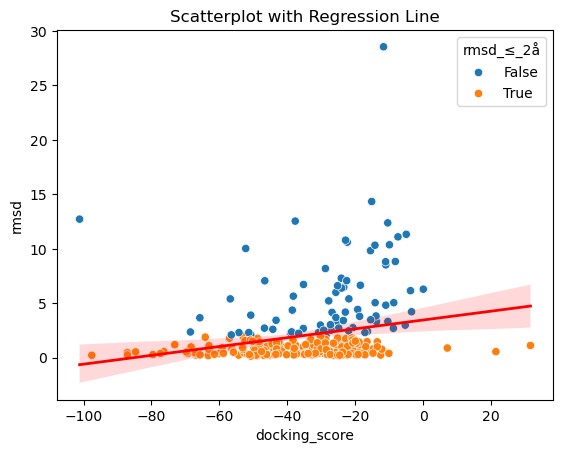

In [7]:
sns.scatterplot(data=df_pb, x="docking_score", y="rmsd", hue="rmsd_≤_2å")
# Add regression line
sns.regplot(
    data=df_pb,
    x="docking_score",
    y="rmsd",
    scatter=False,  # Don't overlay the scatter points again
    color="red",    # Color of the regression line
    line_kws={"linewidth": 2}  # Line properties
)

# Show the plot
plt.title("Scatterplot with Regression Line")
plt.show()

In [26]:
df_pb["rmsd_≤_2å"].value_counts()/df_pb.shape[0]

rmsd_≤_2å
True     0.731183
False    0.268817
Name: count, dtype: float64

### Collec the diffdock restuls

In [45]:
base_outdir = "/Users/aoxu/projects/DrugDiscovery/PoseBench/forks/DiffDock/inference/diffdock_posebusters_benchmark_output_orig_structure_2"
data_dir = "/Users/aoxu/projects/DrugDiscovery/PoseBench/data/posebusters_benchmark_set"
diffdock_df = run_posebusters_all_proteins(base_outdir=base_outdir, data_dir=data_dir)


[SKIP] No answers_7ZDY_6MJ.sdf found in /Users/aoxu/projects/DrugDiscovery/PoseBench/forks/DiffDock/inference/diffdock_posebusters_benchmark_output_orig_structure_2/7ZDY_6MJ
[SKIP] No answers_8F8E_XJI.sdf found in /Users/aoxu/projects/DrugDiscovery/PoseBench/forks/DiffDock/inference/diffdock_posebusters_benchmark_output_orig_structure_2/8F8E_XJI

[INFO] Running PoseBusters for protein=7U3J_L6U
[INFO] Saved /Users/aoxu/projects/DrugDiscovery/PoseBench/forks/DiffDock/inference/diffdock_posebusters_benchmark_output_orig_structure_2/7U3J_L6U/bust_results_7U3J_L6U.csv

[INFO] Running PoseBusters for protein=8AUH_L9I
[INFO] Saved /Users/aoxu/projects/DrugDiscovery/PoseBench/forks/DiffDock/inference/diffdock_posebusters_benchmark_output_orig_structure_2/8AUH_L9I/bust_results_8AUH_L9I.csv
[SKIP] No answers_7XRL_FWK.sdf found in /Users/aoxu/projects/DrugDiscovery/PoseBench/forks/DiffDock/inference/diffdock_posebusters_benchmark_output_orig_structure_2/7XRL_FWK

[INFO] Running PoseBusters for pr

### collect chai-1 results

In [6]:
base_outdir = "/Users/aoxu/projects/DrugDiscovery/PoseBench/forks/chai-lab/inference/chai-lab_posebusters_benchmark_outputs_1"
data_dir = "/Users/aoxu/projects/DrugDiscovery/PoseBench/data/posebusters_benchmark_set"
chai_df = run_posebusters_all_proteins(base_outdir=base_outdir, data_dir=data_dir, rank_file="pred.model_idx_0_ligand_aligned.sdf")
print(chai_df.shape)


[INFO] Running PoseBusters for protein=7ZDY_6MJ
[INFO] Saved /Users/aoxu/projects/DrugDiscovery/PoseBench/forks/chai-lab/inference/chai-lab_posebusters_benchmark_outputs_1/7ZDY_6MJ/bust_results_7ZDY_6MJ.csv

[INFO] Running PoseBusters for protein=8F8E_XJI
[INFO] Saved /Users/aoxu/projects/DrugDiscovery/PoseBench/forks/chai-lab/inference/chai-lab_posebusters_benchmark_outputs_1/8F8E_XJI/bust_results_8F8E_XJI.csv

[INFO] Running PoseBusters for protein=7U3J_L6U
[INFO] Saved /Users/aoxu/projects/DrugDiscovery/PoseBench/forks/chai-lab/inference/chai-lab_posebusters_benchmark_outputs_1/7U3J_L6U/bust_results_7U3J_L6U.csv

[INFO] Running PoseBusters for protein=8AUH_L9I
[INFO] Saved /Users/aoxu/projects/DrugDiscovery/PoseBench/forks/chai-lab/inference/chai-lab_posebusters_benchmark_outputs_1/8AUH_L9I/bust_results_8AUH_L9I.csv

[INFO] Running PoseBusters for protein=7XRL_FWK
[INFO] Saved /Users/aoxu/projects/DrugDiscovery/PoseBench/forks/chai-lab/inference/chai-lab_posebusters_benchmark_outpu

In [7]:
chai_df["rmsd_≤_2å"].value_counts()/chai_df.shape[0]

rmsd_≤_2å
False    0.577206
True     0.422794
Name: count, dtype: float64

### Collect autodock results

In [54]:
base_outdir = "/Users/aoxu/projects/DrugDiscovery/PoseBench/forks/Vina/inference/vina_diffdock_posebusters_benchmark_outputs_1"
data_dir = "/Users/aoxu/projects/DrugDiscovery/PoseBench/data/posebusters_benchmark_set"
vina_df = run_posebusters_all_proteins(base_outdir=base_outdir, data_dir=data_dir, rank_file=None)
print(vina_df.shape)


[INFO] Running PoseBusters for protein=7ZDY_6MJ
[INFO] Saved /Users/aoxu/projects/DrugDiscovery/PoseBench/forks/Vina/inference/vina_diffdock_posebusters_benchmark_outputs_1/7ZDY_6MJ/bust_results_7ZDY_6MJ.csv

[INFO] Running PoseBusters for protein=8F8E_XJI
[INFO] Saved /Users/aoxu/projects/DrugDiscovery/PoseBench/forks/Vina/inference/vina_diffdock_posebusters_benchmark_outputs_1/8F8E_XJI/bust_results_8F8E_XJI.csv

[INFO] Running PoseBusters for protein=7U3J_L6U
[INFO] Saved /Users/aoxu/projects/DrugDiscovery/PoseBench/forks/Vina/inference/vina_diffdock_posebusters_benchmark_outputs_1/7U3J_L6U/bust_results_7U3J_L6U.csv

[INFO] Running PoseBusters for protein=8AUH_L9I
[INFO] Saved /Users/aoxu/projects/DrugDiscovery/PoseBench/forks/Vina/inference/vina_diffdock_posebusters_benchmark_outputs_1/8AUH_L9I/bust_results_8AUH_L9I.csv

[INFO] Running PoseBusters for protein=7XRL_FWK
[INFO] Saved /Users/aoxu/projects/DrugDiscovery/PoseBench/forks/Vina/inference/vina_diffdock_posebusters_benchmark_

In [10]:
diffdock_df = pd.read_csv("/Users/aoxu/projects/DrugDiscovery/PoseBench/forks/DiffDock/inference/diffdock_posebusters_benchmark_output_orig_structure_2/bust_results_aggregated.csv")
df_pb = pd.read_csv("/Users/aoxu/projects/DrugDiscovery/PoseBench/forks/ICM/inference/icm_manual_posebusters_benchmark_outputs_1/bust_results_aggregated.csv")
print(diffdock_df.shape, df_pb.shape)

(215, 127) (279, 127)


In [21]:
# If each df has columns ["protein","ligand","rmsd", "Score", "is_success"], etc.
merged_df = pd.merge(df_pb, diffdock_df,
                     on=["protein"],
                     suffixes=("_icm","_diffdock"))
print(merged_df.shape)
merged_df = pd.merge(merged_df, chai_df, on=["protein"], suffixes=("", "_chai"))
print(merged_df.shape)

(214, 253)
(214, 379)


In [24]:
merged_df.columns.astype(str).str.contains("chai").sum()

0

In [6]:
print(df_pb["rmsd_≤_2å"].value_counts()/df_pb.shape[0], diffdock_df["rmsd_≤_2å"].value_counts()/diffdock_df.shape[0])

rmsd_≤_2å
True     0.731183
False    0.268817
Name: count, dtype: float64 rmsd_≤_2å
False    0.562791
True     0.437209
Name: count, dtype: float64


### A. per-protein success rate

In [7]:
rate_icm = df_pb.groupby("protein")["rmsd_≤_2å"].mean()
rate_diffdock = diffdock_df.groupby("protein")["rmsd_≤_2å"].mean()

# Merge them side by side
compare_rates = pd.DataFrame({
    "ICM_success_rate": rate_icm,
    "DiffDock_success_rate": rate_diffdock
})
# Quick look at sorted difference
compare_rates["delta"] = compare_rates["ICM_success_rate"] - compare_rates["DiffDock_success_rate"]
compare_rates.sort_values("delta", inplace=True)
print(compare_rates)

          ICM_success_rate  DiffDock_success_rate  delta
protein                                                 
8B8H_OJQ               0.0                    1.0   -1.0
7PL1_SFG               0.0                    1.0   -1.0
7NU0_DCL               0.0                    1.0   -1.0
8C5M_MTA               0.0                    1.0   -1.0
7SDD_4IP               0.0                    1.0   -1.0
...                    ...                    ...    ...
8EXL_799               1.0                    NaN    NaN
8EYE_X4I               1.0                    NaN    NaN
8F8E_XJI               1.0                    NaN    NaN
8G0V_YHT               1.0                    NaN    NaN
8SLG_G5A               1.0                    NaN    NaN

[280 rows x 3 columns]


### B. RMSD Distribution


/var/folders/bb/dyy85zps4_lg79d6g6g48ms00000gn/T/ipykernel_53484/3166984888.py:1: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=merged_df, x="rmsd_icm", label="ICM", shade=True)
/var/folders/bb/dyy85zps4_lg79d6g6g48ms00000gn/T/ipykernel_53484/3166984888.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=merged_df, x="rmsd_diffdock", label="DiffDock", shade=True)
/var/folders/bb/dyy85zps4_lg79d6g6g48ms00000gn/T/ipykernel_53484/3166984888.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=merged_df, x="rmsd", label="Chai-1", shade=True)


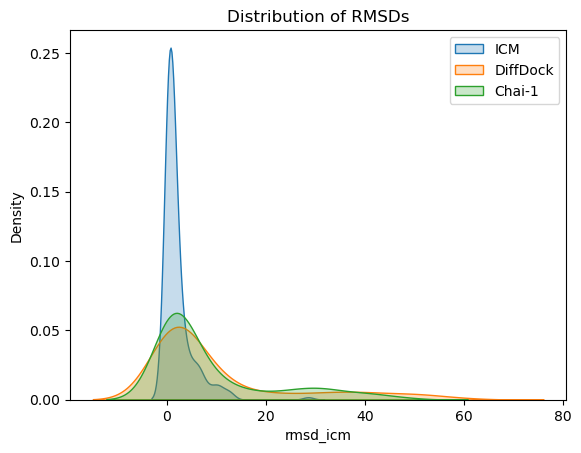

In [25]:
sns.kdeplot(data=merged_df, x="rmsd_icm", label="ICM", shade=True)
sns.kdeplot(data=merged_df, x="rmsd_diffdock", label="DiffDock", shade=True)
sns.kdeplot(data=merged_df, x="rmsd", label="Chai-1", shade=True)
plt.legend()
plt.title("Distribution of RMSDs")
plt.show()

### C. Score vs. Score, RMSD vs. RMSD


In [9]:
# to implement, need to figure out how to get the confidence score for the Diffdock model 

Text(0.5, 1.0, 'ICM RMSD - DiffDock RMSD distribution')

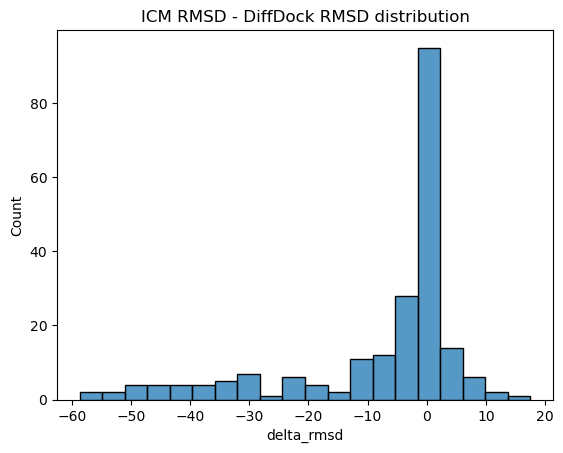

In [10]:
merged_df["delta_rmsd"] = merged_df["rmsd_icm"] - merged_df["rmsd_diffdock"]
sns.histplot(merged_df, x="delta_rmsd", bins=20)
plt.title("ICM RMSD - DiffDock RMSD distribution")

### 	2.	Method Preference


In [48]:
icm_success = merged_df[ (merged_df["rmsd_≤_2å_icm"])].inter
diffdock_success = merged_df[(merged_df["rmsd_≤_2å_diffdock"])]
chai_success = merged_df[(merged_df["rmsd_≤_2å"])]
print(len(icm_success), len(diffdock_success), len(chai_success))

<class 'pandas.core.frame.DataFrame'> 93 99


In [35]:
both_success = merged_df[ (merged_df["rmsd_≤_2å_icm"]) & (merged_df["rmsd_≤_2å_diffdock"]) ]
print("Number of pairs both succeed:", len(both_success))

either_success = merged_df[ (merged_df["rmsd_≤_2å_icm"]) | (merged_df["rmsd_≤_2å_diffdock"]) ]
print("Number of pairs either succedd", len(either_success))

all_success = merged_df[ (merged_df["rmsd_≤_2å_icm"]) | (merged_df["rmsd_≤_2å_diffdock"]) | (merged_df["rmsd_≤_2å"]) ]
print("Number of pairs all succeed", len(all_success))

chai_icm_success = merged_df[ (merged_df["rmsd_≤_2å_icm"]) & (merged_df["rmsd_≤_2å"]) ]
print("Number of pairs both succeed:", len(chai_icm_success))

chai_diffdock_success = merged_df[ (merged_df["rmsd_≤_2å_diffdock"]) & (merged_df["rmsd_≤_2å"]) ]
print("Number of pairs both succeed:", len(chai_diffdock_success))

Number of pairs both succeed: 73
Number of pairs either succedd 176
Number of pairs all succeed 183
Number of pairs both succeed: 80
Number of pairs both succeed: 69


(156, 379)

In [52]:
# relative proportion
print(f"Diffdock overlappped with ICM rmsd < 2a:", len(both_success)/len(diffdock_success))
# print(f"ICM overlapped with Diffdock rmsd < 2a:", len(both_success) / len(icm_success))
print(f"Chai-1 overlapped ICM with rmsd < 2a:", len(chai_icm_success) / len(icm_success))
print(f"Chai-1 overlapped Diffdock with rmsd < 2a:", len(chai_diffdock_success) / len(chai_success))
print(f"Chai-1 overlapped Diffdock with rmsd < 2a:", len(chai_diffdock_success) / len(diffdock_success))

Diffdock overlappped with ICM rmsd < 2a: 0.7849462365591398
Chai-1 overlapped ICM with rmsd < 2a: 0.5128205128205128
Chai-1 overlapped Diffdock with rmsd < 2a: 0.696969696969697
Chai-1 overlapped Diffdock with rmsd < 2a: 0.7419354838709677


In [11]:
merged_df["better_method"] = merged_df.apply(
    lambda row: "ICM" if row["rmsd_icm"] < row["rmsd_diffdock"] else "DiffDock",
    axis=1
)
merged_df["better_method"].value_counts()

**Print out proteins that ICM succesfully predicted while diffdock not**

In [14]:
merged_df[ (merged_df["rmsd_≤_2å_icm"]) & (~merged_df["rmsd_≤_2å_diffdock"]) ]['protein'].unique()

array(['7U3J_L6U', '8AEM_LVF', '7UY4_SMI', '7W06_ITN', '7P5T_5YG',
       '7XQZ_FPF', '7TXK_LW8', '7OFF_VCB', '7LOE_Y84', '7TSF_H4B',
       '7YZU_DO7', '7KQU_YOF', '8D39_QDB', '7OZC_G6S', '7VBU_6I4',
       '5SD5_HWI', '7VWF_K55', '7OPG_06N', '6YRV_PJ8', '6T88_MWQ',
       '7E4L_MDN', '7OMX_CNA', '7UAS_MBU', '7OZ9_NGK', '6Z0R_Q4H',
       '7UJ5_DGL', '7LOU_IFM', '8DHG_T78', '7JMV_4NC', '7NPL_UKZ',
       '7RKW_5TV', '7ZL5_IWE', '7OLI_8HG', '8EAB_VN2', '7NF3_4LU',
       '8FO5_Y4U', '7TUO_KL9', '7P1M_4IU', '7UAW_MF6', '7M6K_YRJ',
       '7BNH_BEZ', '7OEO_V9Z', '7RWS_4UR', '7RH3_59O', '5SAK_ZRY',
       '7NLV_UJE', '7TYP_KUR', '8BTI_RFO', '7CNS_PMV', '7B94_ANP',
       '6XM9_V55', '7LMO_NYO', '7MWN_WI5', '6XBO_5MC', '7DQL_4CL',
       '8GFD_ZHR', '7VQ9_ISY', '7BKA_4JC', '6Z2C_Q5E', '7MOI_HPS',
       '7KZ9_XN7', '7ULC_56B', '7TBU_S3P', '7AN5_RDH', '7N6F_0I1',
       '7SFO_98L', '7NUT_GLP', '7NSW_HC4', '7UXS_OJC', '8DKO_TFB',
       '7V43_C4O', '6ZC3_JOR', '6YMS_OZH', '7N4W_P4V', '7MGT_Z

**Print out proteins that Diffdock successfully predicted while ICM not**

In [15]:
merged_df[ (~merged_df["rmsd_≤_2å_icm"]) & (merged_df["rmsd_≤_2å_diffdock"]) ]['protein'].unique()

array(['7WL4_JFU', '7WPW_F15', '7XFA_D9J', '7NU0_DCL', '7VB8_STL',
       '8C5M_MTA', '7Z1Q_NIO', '7QE4_NGA', '7BJJ_TVW', '7UYB_OK0',
       '7PL1_SFG', '7SDD_4IP', '6YR2_T1C', '8B8H_OJQ', '7NP6_UK8',
       '7UQ3_O2U', '6TW7_NZB', '7ZOC_T8E', '8BOM_QU6', '7MY1_IPE'],
      dtype=object)

In [16]:
merged_df[ (~merged_df["rmsd_≤_2å_icm"])]['protein'].unique()

array(['8AUH_L9I', '7WL4_JFU', '7SZA_DUI', '7OSO_0V1', '6ZPB_3D1',
       '7U0U_FK5', '7Q2B_M6H', '7NFB_GEN', '8AP0_PRP', '7WPW_F15',
       '7CUO_PHB', '7C8Q_DSG', '7XFA_D9J', '7NU0_DCL', '7VB8_STL',
       '7L5F_XNG', '8C5M_MTA', '7Z1Q_NIO', '7FB7_8NF', '7JG0_GAR',
       '7W05_GMP', '6VTA_AKN', '7TOM_5AD', '7WUX_6OI', '7Z2O_IAJ',
       '8HO0_3ZI', '7QE4_NGA', '7XBV_APC', '7PK0_BYC', '8A2D_KXY',
       '8HFN_XGC', '7JY3_VUD', '7BJJ_TVW', '7PRI_7TI', '7L7C_XQ1',
       '7CD9_FVR', '7RNI_60I', '7UYB_OK0', '7PL1_SFG', '7C3U_AZG',
       '7SDD_4IP', '6YR2_T1C', '8DSC_NCA', '8B8H_OJQ', '7NP6_UK8',
       '7UQ3_O2U', '6YYO_Q1K', '7QTA_URI', '8D19_GSH', '7A9E_R4W',
       '6TW7_NZB', '7ZOC_T8E', '6YJA_2BA', '7O0N_CDP', '8BOM_QU6',
       '7MY1_IPE', '6ZAE_ACV', '7AFX_R9K'], dtype=object)

In [33]:
merged_df[ (merged_df["rmsd_≤_2å"]) & (merged_df["rmsd_≤_2å_diffdock"]) ]['protein'].unique()

array(['7X9K_8OG', '7WQQ_5Z6', '7USH_82V', '7WPW_F15', '7MMH_ZJY',
       '7LEV_0JO', '7QF4_RBF', '6Z14_Q4Z', '7XFA_D9J', '7R7R_AWJ',
       '7NU0_DCL', '7RC3_SAH', '7F5D_EUO', '8C5M_MTA', '7THI_PGA',
       '7T0D_FPP', '7Z1Q_NIO', '7SCW_GSP', '6ZCY_QF8', '7EPV_FDA',
       '7RSV_7IQ', '7T1D_E7K', '8AY3_OE3', '7OFK_VCH', '7QE4_NGA',
       '6XG5_TOP', '8EX2_Q2Q', '7V14_ORU', '7WDT_NGS', '8A1H_DLZ',
       '7V3S_5I9', '7R9N_F97', '7XI7_4RI', '6Z1C_7EY', '7VC5_9SF',
       '7PGX_FMN', '7V3N_AKG', '6M73_FNR', '7UYB_OK0', '7PL1_SFG',
       '7WJB_BGC', '7LT0_ONJ', '7ZF0_DHR', '8FLV_ZB9', '7NP6_UK8',
       '7UQ3_O2U', '7R59_I5F', '8AAU_LH0', '7N4N_0BK', '7Q27_8KC',
       '7F51_BA7', '7N03_ZRP', '7BMI_U4B', '6TW7_NZB', '7DUA_HJ0',
       '8BOM_QU6', '7SIU_9ID', '7PRM_81I', '7DKT_GLF', '7ROU_66I',
       '7ZU2_DHT', '6M2B_EZO', '7ES1_UDP', '7QPP_VDX', '7ELT_TYM',
       '7P4C_5OV', '5SB2_1K2', '7BCP_GCO', '7BTT_F8R'], dtype=object)